In [20]:
import matplotlib.pyplot as plt
import h5py
from numpy import *
import numpy as np
from scipy import stats
import math
from matplotlib.ticker import MultipleLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.signal import savgol_filter
from bar_funcs import *

In [29]:
path = 'barrada/'
paths1 = [path]

In [30]:
n_snapshots_ = 281

In [31]:
time = np.empty(n_snapshots_)

In [32]:
%%time
for p, path in enumerate(paths1):

    for j in range (0, n_snapshots_):
        index = str(j).zfill(3)
        snapshot = path + f'snapshot_{index}.hdf5'

        #ler snapshot
        f = h5py.File(snapshot, 'r')
        
        if p == 0:
            time[j] = 0.0 + round(f['Header'].attrs['Time'], 2)

        #ler info disco e corrigir posição - centro de massa
        f_disk = f['PartType2']

        x_disk = np.array(f_disk['Coordinates'][:,0])
        y_disk = np.array(f_disk['Coordinates'][:,1])
        z_disk = np.array(f_disk['Coordinates'][:,2])
        m_disk = np.array(f_disk['Masses'])
        vx_disk = np.array(f_disk['Velocities'][:,0])
        vy_disk = np.array(f_disk['Velocities'][:,1])
        vz_disk = np.array(f_disk['Velocities'][:,2])
        Ndisk = len(np.array(f_disk['ParticleIDs']))
                   
        x_new_disk, y_new_disk, z_new_disk = shift_com(m=m_disk, x=x_disk, y=y_disk, z=z_disk)
        vx_new_disk, vy_new_disk, vz_new_disk = shift_com(m_disk, vx_disk, vy_disk, vz_disk)

        #corrigir posição - momento angular
        theta, phi = theta_phi(N=Ndisk, x=x_new_disk, y=y_new_disk, z=z_new_disk, vx=vx_new_disk,
                           vy=vy_new_disk, vz=vz_new_disk, m=m_disk)
    
        x, y, vx, vy = angular_momentum_1(N=Ndisk, x=x_new_disk, y=y_new_disk, vx=vx_new_disk,
                                      vy=vy_new_disk, theta=theta)
   
        x, z, vx, vz = angular_momentum_2(N=Ndisk, x=x, z=z_new_disk, vx=vx, vz=vz_new_disk, phi=phi)

        #alinhar barra
        # thetas = theta_bar(m=m_disk, x=x, y=y, Rmax=10.0)
        # x_new_disk2, y_new_disk2 = corr_theta_b(N=Ndisk, x=x, y=y, theta=thetas)
        # vx_new_disk2, vy_new_disk2 = corr_theta_b(N=Ndisk, x=vx, y=vy, theta=thetas) 
        
        #calcular A1
        if p == 0:
            A1, r = A1_warp(m=m_disk, x=x, y=y, z=z, Rmax=30.0, Nbins=30, n_snapshots=n_snapshots_)  
            out = transpose([A1,r])
            header = f't={time[j]} \n A1       r'
            savetxt(path + 'a1/' + f'a1-{j}.txt', out, fmt='%1.6e', header=header)

CPU times: user 1h 30min 31s, sys: 1min 36s, total: 1h 32min 7s
Wall time: 1h 30min 25s


In [33]:
plt.rcParams['figure.figsize'  ] = (3.4,2.0)
plt.rcParams['font.size'       ] = 8
plt.rcParams['legend.fontsize' ] = 8
plt.rcParams['legend.frameon'  ] = False
plt.rcParams['font.family'     ] = 'STIXGeneral'
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['xtick.direction' ] = 'in'
plt.rcParams['ytick.direction' ] = 'in'
plt.rcParams['xtick.top'       ] = True
plt.rcParams['ytick.right'     ] = True
plt.rcParams['xtick.major.size'] = 2
plt.rcParams['xtick.minor.size'] = 1
plt.rcParams['ytick.major.size'] = 2
plt.rcParams['ytick.minor.size'] = 1
plt.rcParams['xtick.major.width'] = 0.75
plt.rcParams['xtick.minor.width'] = 0.5
plt.rcParams['ytick.major.width'] = 0.75
plt.rcParams['ytick.minor.width'] = 0.5

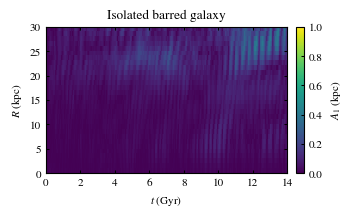

In [34]:
Qlist = []

for j in range (0, n_snapshots_):
    doc = path + 'a1/'+ f'a1-{j}.txt'
    A1, R = np.loadtxt(doc, unpack=True)
    Qlist.append(A1)

Qlist = np.transpose(Qlist)
    
tmin = 0
tmax = 14

Rmin = 0
Rmax = 30

# Qmin = Qlist.min()
# Qmax = Qlist.max()
   
fig, ax = plt.subplots(nrows=1, ncols=1)

extent = [tmin, tmax, Rmin, Rmax]
   
im = plt.imshow(Qlist, extent=extent, origin='lower', vmin=0.0, vmax=1.0, cmap='viridis', 
                interpolation='nearest', aspect='auto')

cb = plt.colorbar(im, ax=ax, shrink=1.0, aspect=18, pad=0.03)
#cb.mappable.set_clim(Qmin, Qmax)

# a1_max = round(Qmax, 2)
# a1_min = round(Qmin, 2)
# cb.set_ticks(np.linspace(a1_min, a1_max, 5))
#cb.set_ticks([0.0, 0.25, 0.5, 0.75])
cb.set_label(r'$A_1$ (kpc)')

ax.set_xlabel(r'$t$ (Gyr)')
ax.set_ylabel(r'$R$ (kpc)')

ax.set_xlim(tmin, tmax)
ax.set_ylim(Rmin, Rmax)

ax.set_title('Isolated barred galaxy')

fig.tight_layout(pad=0.1)    

plt.savefig('a1-barrada-5.png', dpi=300)

In [35]:
path = 'satelites/teste-nogas-05-20/'
paths2 = [path]

In [36]:
n_snapshots = 121

In [37]:
time = np.empty(n_snapshots)

In [38]:
%%time
for p, path in enumerate(paths2):

    for j in range (0, n_snapshots):
        index = str(j).zfill(3)
        snapshot = path + f'snapshot_{index}.hdf5'

        #ler snapshot
        f = h5py.File(snapshot, 'r')
        
        if p == 0:
            time[j] = 0.0 + round(f['Header'].attrs['Time'], 2)

        #ler info disco e corrigir posição
        f_disk = f['PartType2']

        x_disk = np.array(f_disk['Coordinates'][:,0])
        y_disk = np.array(f_disk['Coordinates'][:,1])
        z_disk = np.array(f_disk['Coordinates'][:,2])
        m_disk = np.array(f_disk['Masses'])
        vx_disk = np.array(f_disk['Velocities'][:,0])
        vy_disk = np.array(f_disk['Velocities'][:,1])
        vz_disk = np.array(f_disk['Velocities'][:,2])
        Ndisk = len(np.array(f_disk['ParticleIDs']))
                   
        x_new_disk, y_new_disk, z_new_disk = shift_com(m=m_disk, x=x_disk, y=y_disk, z=z_disk)
        vx_new_disk, vy_new_disk, vz_new_disk = shift_com(m=m_disk, x=vx_disk, y=vy_disk, z=vz_disk)

        #corrigir posição - momento angular
        theta, phi = theta_phi(N=Ndisk, x=x_new_disk, y=y_new_disk, z=z_new_disk, vx=vx_new_disk,
                           vy=vy_new_disk, vz=vz_new_disk, m=m_disk)
    
        x, y, vx, vy = angular_momentum_1(N=Ndisk, x=x_new_disk, y=y_new_disk, vx=vx_new_disk,
                                      vy=vy_new_disk, theta=theta)
   
        x, z, vx, vz = angular_momentum_2(N=Ndisk, x=x, z=z_new_disk, vx=vx, vz=vz_new_disk, phi=phi)

        #calcular A1
        if p == 0:
            A1, r = A1_warp(m=m_disk, x=x, y=y, z=z, Rmax=30.0, Nbins=30, n_snapshots=n_snapshots_)  
            out = transpose([A1,r])
            header = f't={time[j]} \n A1       r'
            savetxt(path + 'a1/' + f'a1-{j}.txt', out, fmt='%1.6e', header=header)

CPU times: user 32min 52s, sys: 22.3 s, total: 33min 14s
Wall time: 33min 18s


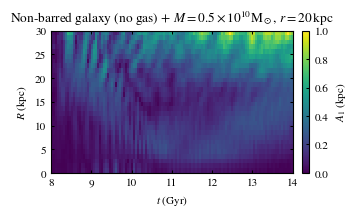

In [39]:
Qlist = []

for j in range (0, n_snapshots):
    doc = path + 'a1/'+ f'a1-{j}.txt'
    A1, R = np.loadtxt(doc, unpack=True)
    Qlist.append(A1)

Qlist = np.transpose(Qlist)
    
tmin = 8
tmax = 14

Rmin = 0
Rmax = 30

# Qmin = Qlist.min()
# Qmax = Qlist.max()
   
fig, ax = plt.subplots(nrows=1, ncols=1)

extent = [tmin, tmax, Rmin, Rmax]
   
im = plt.imshow(Qlist, extent=extent, origin='lower', vmin=0.0, vmax=1.0, cmap='viridis', 
                interpolation='nearest', aspect='auto')

cb = plt.colorbar(im, ax=ax, shrink=1.0, aspect=18, pad=0.03)
#cb.mappable.set_clim(Qmin, Qmax)

# a1_max = round(Qmax, 2)
# a1_min = round(Qmin, 2)
# cb.set_ticks(np.linspace(a1_min, a1_max, 5))
#cb.set_ticks([0.0, 0.25, 0.5, 0.75])
cb.set_label(r'$A_1$ (kpc)')

ax.set_xlabel(r'$t$ (Gyr)')
#ax.set_xticks([8.0, 10.0, 12.0, 14.0]) #8 a 14
ax.set_ylabel(r'$R$ (kpc)')

ax.set_xlim(tmin, tmax)
ax.set_ylim(Rmin, Rmax)

ax.set_title('Non-barred galaxy (no gas) + ' + r'$M=0.5 \times 10^{10}\mathrm{{M}_\odot}, \,r=20 \, \mathrm{kpc}$')

fig.tight_layout(pad=0.1)    

plt.savefig('a1-teste-nogas-4.png', dpi=300)

In [40]:
#caminhos galáxia + satélite
path_01_10 = 'satelites/sat01-10/'
path_01_20 = 'satelites/sat01-20/'
path_01_30 = 'satelites/sat01-30/'
path_05_10 = 'satelites/sat05-10/'
path_05_20 = 'satelites/sat05-20/'
path_05_30 = 'satelites/sat05-30/'
path_1_10 = 'satelites/sat1-10/'
path_1_20 = 'satelites/sat1-20/'
path_1_30 = 'satelites/sat1-30/'

paths = [path_01_10, path_01_20, path_01_30, path_05_10, path_05_20, path_05_30, path_1_10, path_1_20, path_1_30]

In [41]:
n_snapshots = 121

In [42]:
#arrays de tempo
time_01_10 = np.empty(n_snapshots)
time_01_20 = np.empty(n_snapshots)
time_01_30 = np.empty(n_snapshots)

time_05_10 = np.empty(n_snapshots)
time_05_20 = np.empty(n_snapshots)
time_05_30 = np.empty(n_snapshots)

time_1_10 = np.empty(n_snapshots)
time_1_20 = np.empty(n_snapshots)
time_1_30 = np.empty(n_snapshots)

In [43]:
#tempo
for p, path in enumerate(paths):

    for j in range (0, n_snapshots,2): 
        index = str(j).zfill(3)
        snapshot = path + f'snapshot_{index}.hdf5'

        #ler snapshot
        f = h5py.File(snapshot, 'r')
        
        if p == 0:
            time_01_10[j] = round(f['Header'].attrs['Time'], 2)
            
        if p == 1:
            time_01_20[j] = round(f['Header'].attrs['Time'], 2)    
        
        if p == 2:
            time_01_30[j] = round(f['Header'].attrs['Time'], 2)
            
        if p == 3:
            time_05_10[j] = round(f['Header'].attrs['Time'], 2)
            
        if p == 4:
            time_05_20[j] = round(f['Header'].attrs['Time'], 2)
            
        if p == 5:
            time_05_30[j] = round(f['Header'].attrs['Time'], 2)
            
        if p == 6:
            time_1_10[j] = round(f['Header'].attrs['Time'], 2)
            
        if p == 7:
            time_1_20[j] = round(f['Header'].attrs['Time'], 2)
            
        if p == 8:
            time_1_30[j] = round(f['Header'].attrs['Time'], 2)

In [46]:
%%time
for p, path in enumerate(paths):

    for j in range (1, n_snapshots, 2):
        index = str(j).zfill(3)
        snapshot = path + f'snapshot_{index}.hdf5'

        #ler snapshot
        f = h5py.File(snapshot, 'r')

        #ler info disco e corrigir posição
        f_disk = f['PartType2']

        x_disk = np.array(f_disk['Coordinates'][:,0])
        y_disk = np.array(f_disk['Coordinates'][:,1])
        z_disk = np.array(f_disk['Coordinates'][:,2])
        m_disk = np.array(f_disk['Masses'])
        vx_disk = np.array(f_disk['Velocities'][:,0])
        vy_disk = np.array(f_disk['Velocities'][:,1])
        vz_disk = np.array(f_disk['Velocities'][:,2])
        Ndisk = len(np.array(f_disk['ParticleIDs']))
                   
        x_new_disk, y_new_disk, z_new_disk = shift_com(m=m_disk, x=x_disk, y=y_disk, z=z_disk)
        vx_new_disk, vy_new_disk, vz_new_disk = shift_com(m=m_disk, x=vx_disk, y=vy_disk, z=vz_disk)

        #corrigir posição - momento angular
        theta, phi = theta_phi(N=Ndisk, x=x_new_disk, y=y_new_disk, z=z_new_disk, vx=vx_new_disk,
                           vy=vy_new_disk, vz=vz_new_disk, m=m_disk)
    
        x, y, vx, vy = angular_momentum_1(N=Ndisk, x=x_new_disk, y=y_new_disk, vx=vx_new_disk,
                                      vy=vy_new_disk, theta=theta)
   
        x, z, vx, vz = angular_momentum_2(N=Ndisk, x=x, z=z_new_disk, vx=vx, vz=vz_new_disk, phi=phi)


        #calcular A1
        if p == 0:
            A1_01_10, r_01_10 = A1_warp(m=m_disk, x=x, y=y, z=z, Rmax=30.0, Nbins=30, n_snapshots=n_snapshots)  
            out = transpose([A1_01_10, r_01_10])
            header = f'01_10 t={time[j]} \nA1       r'
            savetxt(path + 'a1/' + f'a1-{j}.txt', out, fmt='%1.6e', header=header)

        if p == 1:
            A1_01_20, r_01_20 = A1_warp(m=m_disk, x=x, y=y, z=z, Rmax=30.0, Nbins=30, n_snapshots=n_snapshots)
            out = transpose([A1_01_20, r_01_20])
            header = f'01_20 t={time[j]} \nA1       r'
            savetxt(path + 'a1/' + f'a1-{j}.txt', out, fmt='%1.6e', header=header)

        if p == 2:
            A1_01_30, r_01_30 = A1_warp(m=m_disk, x=x, y=y, z=z, Rmax=30.0, Nbins=30, n_snapshots=n_snapshots)
            out = transpose([A1_01_30, r_01_30])
            header = f'01_30 t={time[j]} \nA1       r'
            savetxt(path + 'a1/' + f'a1-{j}.txt', out, fmt='%1.6e', header=header)
            
        if p == 3:
            A1_05_10, r_05_10 = A1_warp(m=m_disk, x=x, y=y, z=z, Rmax=30.0, Nbins=30, n_snapshots=n_snapshots)
            out = transpose([A1_05_10, r_05_10])
            header = f'05_10 t={time[j]} \nA1       r'
            savetxt(path + 'a1/' + f'a1-{j}.txt', out, fmt='%1.6e', header=header)

        if p == 4:
            A1_05_20, r_05_20 = A1_warp(m=m_disk, x=x, y=y, z=z, Rmax=30.0, Nbins=30, n_snapshots=n_snapshots)
            out = transpose([A1_05_20, r_05_20])
            header = f'05_20 t={time[j]} \nA1       r'
            savetxt(path + 'a1/' + f'a1-{j}.txt', out, fmt='%1.6e', header=header)

        if p == 5:
            A1_05_30, r_05_30 = A1_warp(m=m_disk, x=x, y=y, z=z, Rmax=30.0, Nbins=30, n_snapshots=n_snapshots)
            out = transpose([A1_05_30, r_05_30])
            header = f'05_30 t={time[j]} \nA1       r'
            savetxt(path + 'a1/' + f'a1-{j}.txt', out, fmt='%1.6e', header=header)

        if p == 6:
            A1_1_10, r_1_10 = A1_warp(m=m_disk, x=x, y=y, z=z, Rmax=30.0, Nbins=30, n_snapshots=n_snapshots)
            out = transpose([A1_1_10, r_1_10])
            header = f'1_10 t={time[j]} \nA1       r'
            savetxt(path + 'a1/' + f'a1-{j}.txt', out, fmt='%1.6e', header=header)

        if p == 7:
            A1_1_20, r_1_20 = A1_warp(m=m_disk, x=x, y=y, z=z, Rmax=30.0, Nbins=30, n_snapshots=n_snapshots)
            out = transpose([A1_1_20, r_1_20])
            header = f'1_20 t={time[j]} \nA1       r'
            savetxt(path + 'a1/' + f'a1-{j}.txt', out, fmt='%1.6e', header=header)

        if p == 8:
            A1_1_30, r_1_30 = A1_warp(m=m_disk, x=x, y=y, z=z, Rmax=30.0, Nbins=30, n_snapshots=n_snapshots)
            out = transpose([A1_1_30, r_1_30])
            header = f'1_30 t={time[j]} \nA1       r'
            savetxt(path + 'a1/' + f'a1-{j}.txt', out, fmt='%1.6e', header=header)

CPU times: user 2h 27min 41s, sys: 3min 16s, total: 2h 30min 57s
Wall time: 2h 27min 24s


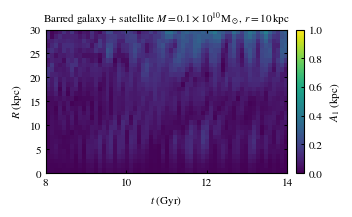

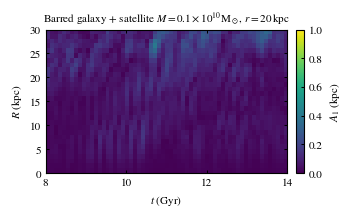

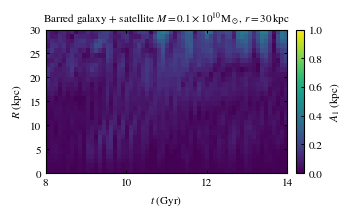

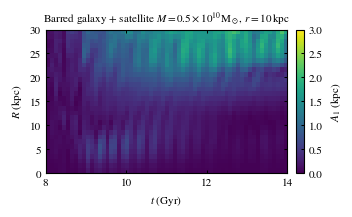

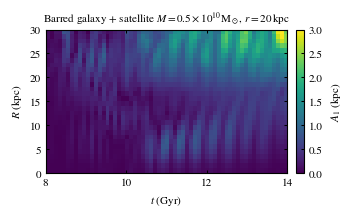

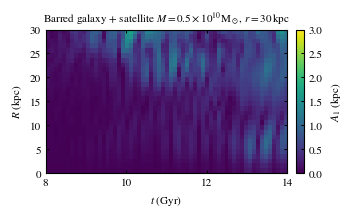

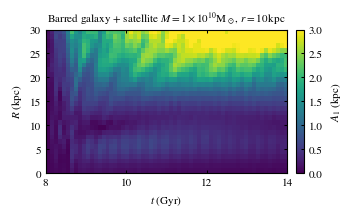

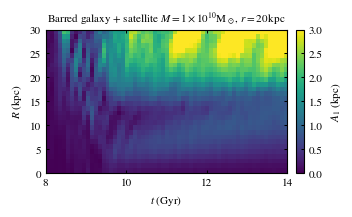

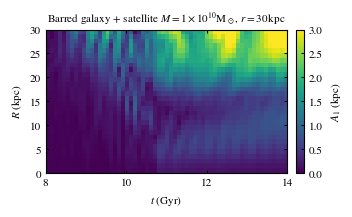

In [45]:
for p, path in enumerate(paths):

    Qlist = []

    if p == 0:
        vmax = 1.0
        title = 'Barred galaxy + satellite ' + r'$M=0.1 \times 10^{10}\mathrm{{M}_\odot}, \,r=10 \, \mathrm{kpc}$'

    if p == 1:
        vmax = 1.0
        title = 'Barred galaxy + satellite ' + r'$M=0.1 \times 10^{10}\mathrm{{M}_\odot}, \,r=20 \, \mathrm{kpc}$'

    if p == 2:
        vmax = 1.0
        title = 'Barred galaxy + satellite ' + r'$M=0.1 \times 10^{10}\mathrm{{M}_\odot}, \,r=30 \, \mathrm{kpc}$'

    if p == 3:
        vmax = 3.0
        title = 'Barred galaxy + satellite ' + r'$M=0.5 \times 10^{10}\mathrm{{M}_\odot}, \,r=10 \, \mathrm{kpc}$'

    if p == 4:
        vmax = 3.0
        title = 'Barred galaxy + satellite ' + r'$M=0.5 \times 10^{10}\mathrm{{M}_\odot}, \,r=20 \, \mathrm{kpc}$'

    if p == 5:
        vmax = 3.0
        title = 'Barred galaxy + satellite ' + r'$M=0.5 \times 10^{10}\mathrm{{M}_\odot}, \,r=30 \, \mathrm{kpc}$'
    
    if p == 6:
        vmax = 3.0
        title = 'Barred galaxy + satellite ' + r'$M=1 \times 10^{10}\mathrm{{M}_\odot}, \,r=10 \, \mathrm{kpc}$'

    if p == 7:
        vmax = 3.0
        title = 'Barred galaxy + satellite ' + r'$M=1 \times 10^{10}\mathrm{{M}_\odot}, \,r=20 \, \mathrm{kpc}$'

    if p == 8:
        vmax = 3.0
        title = 'Barred galaxy + satellite ' + r'$M=1 \times 10^{10}\mathrm{{M}_\odot}, \,r=30 \, \mathrm{kpc}$'
    
        
    for j in range (0, n_snapshots, 2):
        doc = path + 'a1/'+ f'a1-{j}.txt'
        A1, R = np.loadtxt(doc, unpack=True)
        Qlist.append(A1)
    
    Qlist = np.transpose(Qlist)
        
    tmin = 8
    tmax = 14
    
    Rmin = 0
    Rmax = 30
    
    Qmin = Qlist.min()
    Qmax = Qlist.max()
       
    fig, ax = plt.subplots(nrows=1, ncols=1)
    
    extent = [tmin, tmax, Rmin, Rmax]
       
    im = plt.imshow(Qlist, extent=extent, origin='lower', vmin=0.0, vmax=vmax, cmap='viridis', 
                    interpolation='nearest', aspect='auto')
    
    cb = plt.colorbar(im, ax=ax, shrink=1.0, aspect=18, pad=0.03)
    #cb.mappable.set_clim(Qmin, Qmax)
    
    # a1_max = round(Qmax, 2)
    # a1_min = round(Qmin, 2)
    # cb.set_ticks(np.linspace(a1_min, a1_max, 5))
    #cb.set_ticks([0.0, 0.25, 0.5, 0.75])
    cb.set_label(r'$A_1$ (kpc)')
    
    ax.set_xlabel(r'$t$ (Gyr)')
    ax.set_xticks([8.0, 10.0, 12.0, 14.0])
    ax.set_ylabel(r'$R$ (kpc)')
    
    ax.set_xlim(tmin, tmax)
    ax.set_ylim(Rmin, Rmax)

    ax.set_title(title, fontsize=8)
    
    fig.tight_layout(pad=0.1)    
    
    plt.savefig(f'a1-{p}-2.png', dpi=300)

In [19]:
path = 'n_barrada/'
paths1 = [path]

In [20]:
n_snapshots_ = 281

In [21]:
time = np.empty(n_snapshots_)

In [22]:
for p, path in enumerate(paths1):

    for j in range (0, n_snapshots_, 2): 
        index = str(j).zfill(3)
        snapshot = path + f'snapshot_{index}.hdf5'

        #ler snapshot
        f = h5py.File(snapshot, 'r')

        if p == 0:
            time[j] = 0.0 + round(f['Header'].attrs['Time'], 2)

        #ler info disco e stars e corrigir posição
        f_disk = f['PartType2']

        x_disk = np.array(f_disk['Coordinates'][:,0])
        y_disk = np.array(f_disk['Coordinates'][:,1])
        z_disk = np.array(f_disk['Coordinates'][:,2])
        m_disk = np.array(f_disk['Masses'])
                   
        x_new_disk, y_new_disk, z_new_disk = shift_com(m=m_disk, x=x_disk, y=y_disk, z=z_disk)
        
        if j == 0:
            m_star = 0
            x_new_star = 0
            y_new_star = 0
            
        else:
        
            f_star = f['PartType4']

            x_star = np.array(f_star['Coordinates'][:,0])
            y_star = np.array(f_star['Coordinates'][:,1])
            z_star = np.array(f_star['Coordinates'][:,2])
            m_star = np.array(f_star['Masses'])

            x_new_star, y_new_star, z_new_star = shift_com(m=m_star, x=x_star, y=y_star, z=z_star)
 
        #juntar disk + stars
        if j == 0:
            m = m_disk
            x = x_new_disk
            y = y_new_disk
            z = z_new_disk
        
        else:
            m = np.concatenate((m_star,m_disk))
            x = np.concatenate((x_new_star,x_new_disk))
            y = np.concatenate((y_new_star,y_new_disk))
            z = np.concatenate((z_new_star,z_new_disk))

        #calcular força da barra
        if p == 0:
            A1, r = A1_warp(m=m, x=x, y=y, z=z, Rmax=35.0, Nbins=35, n_snapshots=n_snapshots_)  
            out = transpose([A1,r])
            header = f't={time[j]} \n A1       r'
            savetxt(path + 'a1/' + f'a1-{j}-nb.txt', out, fmt='%1.6e', header=header)   

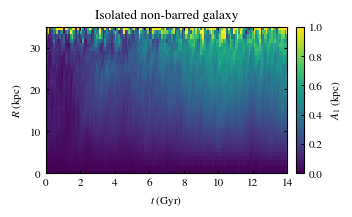

In [23]:
Qlist = []

for j in range (0, n_snapshots_,2):
    doc = path + 'a1/'+ f'a1-{j}-nb.txt'
    A1, R = np.loadtxt(doc, unpack=True)
    Qlist.append(A1)

Qlist = np.transpose(Qlist)
    
tmin = 0
tmax = 14

Rmin = 0
Rmax = 35

# Qmin = Qlist.min()
# Qmax = Qlist.max()
   
fig, ax = plt.subplots(nrows=1, ncols=1)

extent = [tmin, tmax, Rmin, Rmax]
   
im = plt.imshow(Qlist, extent=extent, origin='lower', vmin=0.0, vmax=1.0, cmap='viridis', 
                interpolation='nearest', aspect='auto')

cb = plt.colorbar(im, ax=ax, shrink=1.0, aspect=18, pad=0.03)
#cb.mappable.set_clim(Qmin, Qmax)

# a1_max = round(Qmax, 2)
# a1_min = round(Qmin, 2)
# cb.set_ticks(np.linspace(a1_min, a1_max, 5))
#cb.set_ticks([0.0, 0.25, 0.5, 0.75])
cb.set_label(r'$A_1$ (kpc)')

ax.set_xlabel(r'$t$ (Gyr)')
ax.set_xticks([0.0, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0])
ax.set_ylabel(r'$R$ (kpc)')

ax.set_xlim(tmin, tmax)
ax.set_ylim(Rmin, Rmax)

ax.set_title('Isolated non-barred galaxy')

fig.tight_layout(pad=0.1)    

plt.savefig('a1-n-barrada.png', dpi=300)

In [24]:
#caminhos galáxia + satélite
path_01_10 = 'satelites/nb-sat01-10/'
path_01_20 = 'satelites/nb-sat01-20/'
path_01_30 = 'satelites/nb-sat01-30/'
path_05_10 = 'satelites/nb-sat05-10/'
path_05_20 = 'satelites/nb-sat05-20/'
path_05_30 = 'satelites/nb-sat05-30/'
path_1_10 = 'satelites/nb-sat1-10/'
path_1_20 = 'satelites/nb-sat1-20/'
path_1_30 = 'satelites/nb-sat1-30/'

paths = [path_01_10, path_01_20, path_01_30, path_05_10, path_05_20, path_05_30, path_1_10, path_1_20, path_1_30]

In [25]:
n_snapshots = 121

In [26]:
#arrays de tempo
time_01_10 = np.empty(n_snapshots)
time_01_20 = np.empty(n_snapshots)
time_01_30 = np.empty(n_snapshots)

time_05_10 = np.empty(n_snapshots)
time_05_20 = np.empty(n_snapshots)
time_05_30 = np.empty(n_snapshots)

time_1_10 = np.empty(n_snapshots)
time_1_20 = np.empty(n_snapshots)
time_1_30 = np.empty(n_snapshots)

In [27]:
#tempo
for p, path in enumerate(paths):

    for j in range (0, n_snapshots,2): 
        index = str(j).zfill(3)
        snapshot = path + f'snapshot_{index}.hdf5'

        #ler snapshot
        f = h5py.File(snapshot, 'r')
        
        if p == 0:
            time_01_10[j] = round(f['Header'].attrs['Time'], 2)
            
        if p == 1:
            time_01_20[j] = round(f['Header'].attrs['Time'], 2)    
        
        if p == 2:
            time_01_30[j] = round(f['Header'].attrs['Time'], 2)
            
        if p == 3:
            time_05_10[j] = round(f['Header'].attrs['Time'], 2)
            
        if p == 4:
            time_05_20[j] = round(f['Header'].attrs['Time'], 2)
            
        if p == 5:
            time_05_30[j] = round(f['Header'].attrs['Time'], 2)
            
        if p == 6:
            time_1_10[j] = round(f['Header'].attrs['Time'], 2)
            
        if p == 7:
            time_1_20[j] = round(f['Header'].attrs['Time'], 2)
            
        if p == 8:
            time_1_30[j] = round(f['Header'].attrs['Time'], 2)

In [28]:
for p, path in enumerate(paths):

    for j in range (0, n_snapshots, 2):
        index = str(j).zfill(3)
        snapshot = path + f'snapshot_{index}.hdf5'

        #ler snapshot
        f = h5py.File(snapshot, 'r')

        #ler info disco e corrigir posição
        f_disk = f['PartType2']

        x_disk = np.array(f_disk['Coordinates'][:,0])
        y_disk = np.array(f_disk['Coordinates'][:,1])
        z_disk = np.array(f_disk['Coordinates'][:,2])
        m_disk = np.array(f_disk['Masses'])
                   
        x_new_disk, y_new_disk, z_new_disk = shift_com(m=m_disk, x=x_disk, y=y_disk, z=z_disk)

        if j == 0:
            m_star = 0
            x_new_star = 0
            y_new_star = 0
            
        else:
            f_star = f['PartType4']

            x_star = np.array(f_star['Coordinates'][:,0])
            y_star = np.array(f_star['Coordinates'][:,1])
            z_star = np.array(f_star['Coordinates'][:,2])
            m_star = np.array(f_star['Masses'])

            x_new_star, y_new_star, z_new_star = shift_com(m=m_star, x=x_star, y=y_star, z=z_star)
 
        #juntar disk + stars
        if j == 0:
            m = m_disk
            x = x_new_disk
            y = y_new_disk
            z = z_new_disk
        
        else:
            m = np.concatenate((m_star,m_disk))
            x = np.concatenate((x_new_star,x_new_disk))
            y = np.concatenate((y_new_star,y_new_disk))
            z = np.concatenate((z_new_star,z_new_disk))
        
        #calcular A1
        if p == 0:
            A1_01_10, r_01_10 = A1_warp(m=m, x=x, y=y, z=z, 
                                        Rmax=35.0, Nbins=35, n_snapshots=n_snapshots)  
            out = transpose([A1_01_10, r_01_10])
            header = f'01_10 t={time[j]} \nA1       r'
            savetxt(path + 'a1/' + f'a1-{j}.txt', out, fmt='%1.6e', header=header)

        if p == 1:
            A1_01_20, r_01_20 = A1_warp(m=m, x=x, y=y, z=z,
                                        Rmax=35.0, Nbins=35, n_snapshots=n_snapshots)  
            out = transpose([A1_01_20, r_01_20])
            header = f'01_20 t={time[j]} \nA1       r'
            savetxt(path + 'a1/' + f'a1-{j}.txt', out, fmt='%1.6e', header=header)

        if p == 2:
            A1_01_30, r_01_30 = A1_warp(m=m, x=x, y=y, z=z,
                                        Rmax=35.0, Nbins=35, n_snapshots=n_snapshots)  
            out = transpose([A1_01_30, r_01_30])
            header = f'01_30 t={time[j]} \nA1       r'
            savetxt(path + 'a1/' + f'a1-{j}.txt', out, fmt='%1.6e', header=header)
            
        if p == 3:
            A1_05_10, r_05_10 = A1_warp(m=m, x=x, y=y, z=z,
                                        Rmax=35.0, Nbins=35, n_snapshots=n_snapshots)  
            out = transpose([A1_05_10, r_05_10])
            header = f'05_10 t={time[j]} \nA1       r'
            savetxt(path + 'a1/' + f'a1-{j}.txt', out, fmt='%1.6e', header=header)

        if p == 4:
            A1_05_20, r_05_20 = A1_warp(m=m, x=x, y=y, z=z,
                                        Rmax=35.0, Nbins=35, n_snapshots=n_snapshots)  
            out = transpose([A1_05_20, r_05_20])
            header = f'05_20 t={time[j]} \nA1       r'
            savetxt(path + 'a1/' + f'a1-{j}.txt', out, fmt='%1.6e', header=header)

        if p == 5:
            A1_05_30, r_05_30 = A1_warp(m=m, x=x, y=y, z=z,
                                        Rmax=35.0, Nbins=35, n_snapshots=n_snapshots)  
            out = transpose([A1_05_30, r_05_30])
            header = f'05_30 t={time[j]} \nA1       r'
            savetxt(path + 'a1/' + f'a1-{j}.txt', out, fmt='%1.6e', header=header)

        if p == 6:
            A1_1_10, r_1_10 = A1_warp(m=m, x=x, y=y, z=z,
                                        Rmax=35.0, Nbins=35, n_snapshots=n_snapshots)  
            out = transpose([A1_1_10, r_1_10])
            header = f'1_10 t={time[j]} \nA1       r'
            savetxt(path + 'a1/' + f'a1-{j}.txt', out, fmt='%1.6e', header=header)

        if p == 7:
            A1_1_20, r_1_20 = A1_warp(m=m, x=x, y=y, z=z,
                                        Rmax=35.0, Nbins=35, n_snapshots=n_snapshots)  
            out = transpose([A1_1_20, r_1_20])
            header = f'1_20 t={time[j]} \nA1       r'
            savetxt(path + 'a1/' + f'a1-{j}.txt', out, fmt='%1.6e', header=header)

        if p == 8:
            A1_1_30, r_1_30 = A1_warp(m=m, x=x, y=y, z=z,
                                        Rmax=35.0, Nbins=35, n_snapshots=n_snapshots)  
            out = transpose([A1_1_30, r_1_30])
            header = f'1_30 t={time[j]} \nA1       r'
            savetxt(path + 'a1/' + f'a1-{j}.txt', out, fmt='%1.6e', header=header)

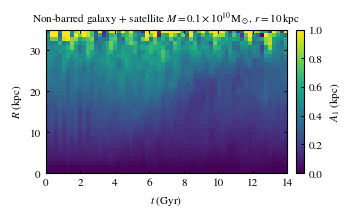

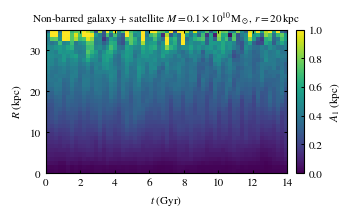

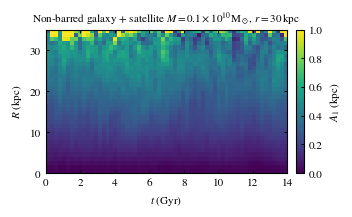

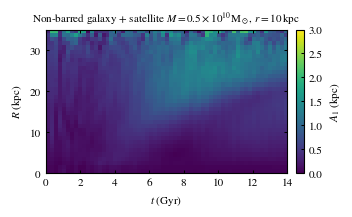

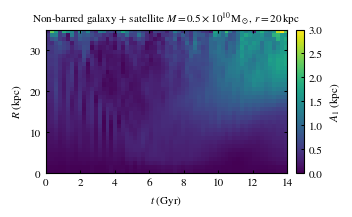

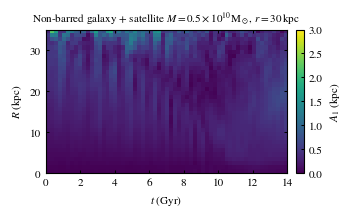

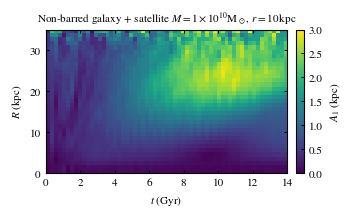

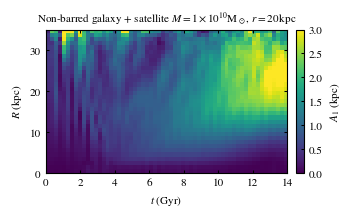

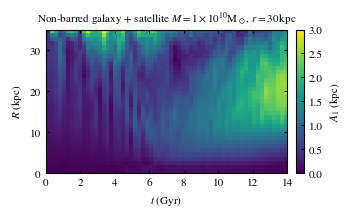

In [29]:
for p, path in enumerate(paths):

    Qlist = []

    if p == 0:
        vmax = 1.0
        title = 'Non-barred galaxy + satellite ' + r'$M=0.1 \times 10^{10}\mathrm{{M}_\odot}, \,r=10 \, \mathrm{kpc}$'

    if p == 1:
        vmax = 1.0
        title = 'Non-barred galaxy + satellite ' + r'$M=0.1 \times 10^{10}\mathrm{{M}_\odot}, \,r=20 \, \mathrm{kpc}$'

    if p == 2:
        vmax = 1.0
        title = 'Non-barred galaxy + satellite ' + r'$M=0.1 \times 10^{10}\mathrm{{M}_\odot}, \,r=30 \, \mathrm{kpc}$'

    if p == 3:
        vmax = 3.0
        title = 'Non-barred galaxy + satellite ' + r'$M=0.5 \times 10^{10}\mathrm{{M}_\odot}, \,r=10 \, \mathrm{kpc}$'

    if p == 4:
        vmax = 3.0
        title = 'Non-barred galaxy + satellite ' + r'$M=0.5 \times 10^{10}\mathrm{{M}_\odot}, \,r=20 \, \mathrm{kpc}$'

    if p == 5:
        vmax = 3.0
        title = 'Non-barred galaxy + satellite ' + r'$M=0.5 \times 10^{10}\mathrm{{M}_\odot}, \,r=30 \, \mathrm{kpc}$'
    
    if p == 6:
        vmax = 3.0
        title = 'Non-barred galaxy + satellite ' + r'$M=1 \times 10^{10}\mathrm{{M}_\odot}, \,r=10 \, \mathrm{kpc}$'

    if p == 7:
        vmax = 3.0
        title = 'Non-barred galaxy + satellite ' + r'$M=1 \times 10^{10}\mathrm{{M}_\odot}, \,r=20 \, \mathrm{kpc}$'

    if p == 8:
        vmax = 3.0
        title = 'Non-barred galaxy + satellite ' + r'$M=1 \times 10^{10}\mathrm{{M}_\odot}, \,r=30 \, \mathrm{kpc}$'
    
        
    for j in range (0, n_snapshots, 2):
        doc = path + 'a1/'+ f'a1-{j}.txt'
        A1, R = np.loadtxt(doc, unpack=True)
        Qlist.append(A1)
    
    Qlist = np.transpose(Qlist)
        
    tmin = 0
    tmax = 14
    
    Rmin = 0
    Rmax = 35
    
    Qmin = Qlist.min()
    Qmax = Qlist.max()
       
    fig, ax = plt.subplots(nrows=1, ncols=1)
    
    extent = [tmin, tmax, Rmin, Rmax]
       
    im = plt.imshow(Qlist, extent=extent, origin='lower', vmin=0.0, vmax=vmax, cmap='viridis', 
                    interpolation='nearest', aspect='auto')
    
    cb = plt.colorbar(im, ax=ax, shrink=1.0, aspect=18, pad=0.03)
    #cb.mappable.set_clim(Qmin, Qmax)
    
    # a1_max = round(Qmax, 2)
    # a1_min = round(Qmin, 2)
    # cb.set_ticks(np.linspace(a1_min, a1_max, 5))
    #cb.set_ticks([0.0, 0.25, 0.5, 0.75])
    cb.set_label(r'$A_1$ (kpc)')
    
    ax.set_xlabel(r'$t$ (Gyr)')
    ax.set_xticks([8.0, 10.0, 12.0, 14.0])
    ax.set_ylabel(r'$R$ (kpc)')
    
    ax.set_xlim(tmin, tmax)
    ax.set_ylim(Rmin, Rmax)

    ax.set_title(title, fontsize=8)
    
    fig.tight_layout(pad=0.1)    
    
    plt.savefig(f'a1-nb-{p}.png', dpi=300)